# **Introduction**

In this assignment, you will work with a dataset that includes The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. The target variable of interest in this dataset is the median value of owner-occupied homes (MEDV), which serves as a proxy for the house prices.
First, you will start by fitting a basic regression model using scikit-learn (sklearn) to establish a baseline for comparison. This basic regression model will serve as a reference point for evaluating the performance of more sophisticated models incorporating regularization techniques.

Furthermore, you will apply L1 (Lasso) and L2 (Ridge) regularization techniques to refine your predictions and evaluate the impact of these methods on the accuracy of your results. Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function, encouraging simpler models with smaller coefficients. L1 regularization (Lasso) encourages sparsity by penalizing the absolute values of coefficients, while L2 regularization (Ridge) penalizes the square of coefficients. By incorporating these regularization techniques, you aim to improve the generalization performance of your regression models and obtain more robust predictions of house prices in the Boston area.

## Imports

In [15]:
import os
import pandas
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
from matplotlib import pyplot as plt

# !wget -O /HousingData.csv "https://www.dropbox.com/scl/fi/j3rxgrd8l7fgczzhiedlp/new.csv?rlkey=yngaf57gumhtmm3hxffk20qll&dl=0"

# Load and Explore

Load the dataset (as a dataframe) using pandas and display the top 5 rows of the dataframe and then check for missing values and impute missing values with mean

In [69]:
file_path = './HousingData.csv'
data = pd.read_csv(file_path)

print("Top 5 rows of the dataframe:")
print(data.head())

print("\nMissing values before imputation:")
print(data.isnull().sum())

data.fillna(data.mean(), inplace=True)

Top 5 rows of the dataframe:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  222     18.7   

        B      LSTAT  MEDV  
0  396.90   4.980000  24.0  
1  396.90   9.140000  21.6  
2  392.83   4.030000  34.7  
3  394.63   2.940000  33.4  
4  396.90  12.715432  36.2  

Missing values before imputation:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


Get a brief description of the dataset

In [70]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   TAX      506 non-null    int64  
 9   PTRATIO  506 non-null    float64
 10  B        506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 51.5 KB
None
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.545770   22.92

Extract only the features from the dataframe by removing the target column and then Convert the new dataframe into a numpy array
</br>
Note: **Do not remove the previous dataframe.**


# Preprocessing

In [71]:
# TODO: drop MEDV and convert to numpy array
data_without_MEDV = data.drop(columns=['MEDV'])
data_array = data_without_MEDV.to_numpy()

print(data_array)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]


look for outliers using box plot and if There are some outliers in data, use StandardScaler can help in scaling data.

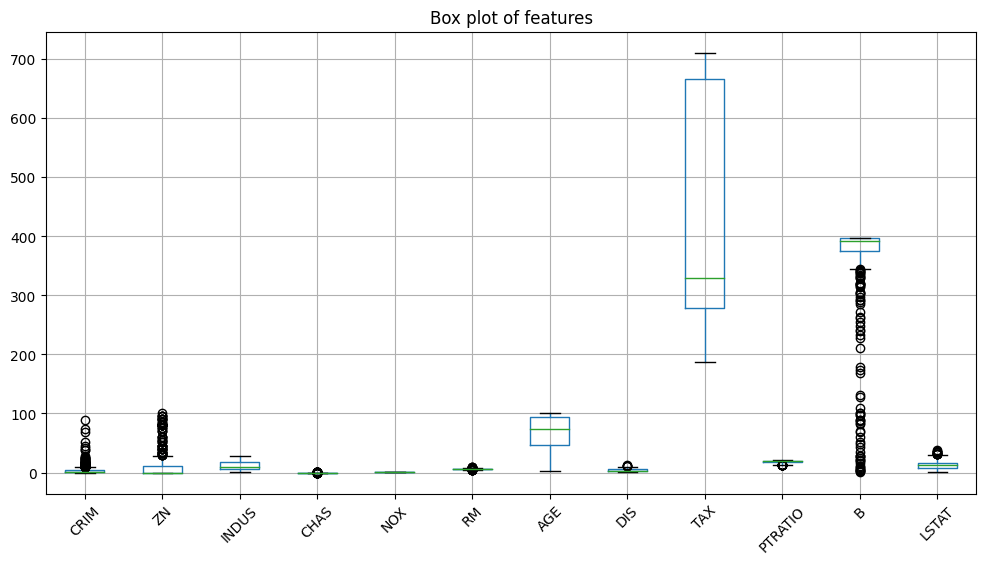

In [72]:
plt.figure(figsize=(12, 6))
data_without_MEDV.boxplot()
plt.title('Box plot of features')
plt.xticks(rotation=45)
plt.show()

# Check for outliers in each feature
Q1 = data_without_MEDV.quantile(0.25)
Q3 = data_without_MEDV.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data_without_MEDV < (Q1 - 1.5 * IQR)) | (data_without_MEDV > (Q3 + 1.5 * IQR))).any()

if outliers.any():
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_without_MEDV)
    scaled_df = pd.DataFrame(scaled_data, columns=data_without_MEDV.columns)

add polynomial features to increase model complexity!



In [78]:
features_to_poly = ['ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
degree = 2
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
poly_data = poly_features.fit_transform(scaled_df[features_to_poly])
poly_column_names = poly_features.get_feature_names_out(features_to_poly)
poly_df = pd.DataFrame(poly_data, columns=poly_column_names)
data_with_poly_features = pd.concat([scaled_df, poly_df], axis=1)

Extract the target column from the previously mentioned DataFrame and transform it into a new NumPy array, named y.

In [79]:
y = data['MEDV'].to_numpy()



Split the dataset into two parts such that the training set contains 80% of the samples.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(data_with_poly_features, y, test_size=0.2, random_state=42)

# Training


Fit a linear regressor to the data. (Use sklearn)


In [81]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression()

Get the coefficients of the variables and visualize it

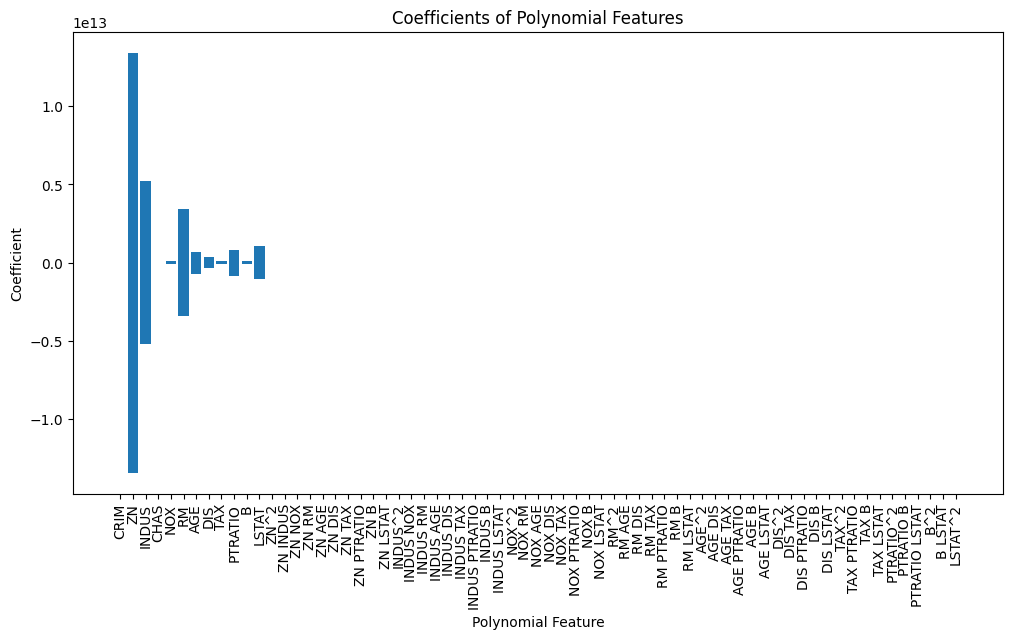

In [82]:
coefficients = linear_regressor.coef_

plt.figure(figsize=(12, 6))
plt.bar(data_with_poly_features.columns, coefficients)
plt.title('Coefficients of Polynomial Features')
plt.xlabel('Polynomial Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

Get the score value of sklearn regressor on train dataset</br>
if you are not familiar with R-squared concept see the link below:
[R-squared](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)



In [83]:
# TODO: Calculate R² score and MSE on the training dataset
y_train_pred = linear_regressor.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

print("R² score on training set:", r2_train)
print("Mean Squared Error (MSE) on training set:", mse_train)

R² score on training set: 0.9006279573511032
Mean Squared Error (MSE) on training set: 8.632787590743488


Predict the value of "y" for each "x" belonging to the "testing" set

In [84]:
y_test_pred = linear_regressor.predict(X_test)

# Lasso Regularization(L1)

L1 regularization, also known as Lasso (Least Absolute Shrinkage and Selection Operator) regularization, is a technique used in regression models that encourages simplicity and sparsity in the model coefficients. This is achieved by adding a penalty equal to the absolute value of the magnitude of coefficients to the loss function.\
</br>
Train a regression model using L1 regularization.

In [85]:
# TODO: Use Lasso from sklearn library
lasso_regressor = Lasso(alpha=0.5)
lasso_regressor.fit(X_train, y_train)

Lasso(alpha=0.5)

Get the coefficients of the variables and visualize it.

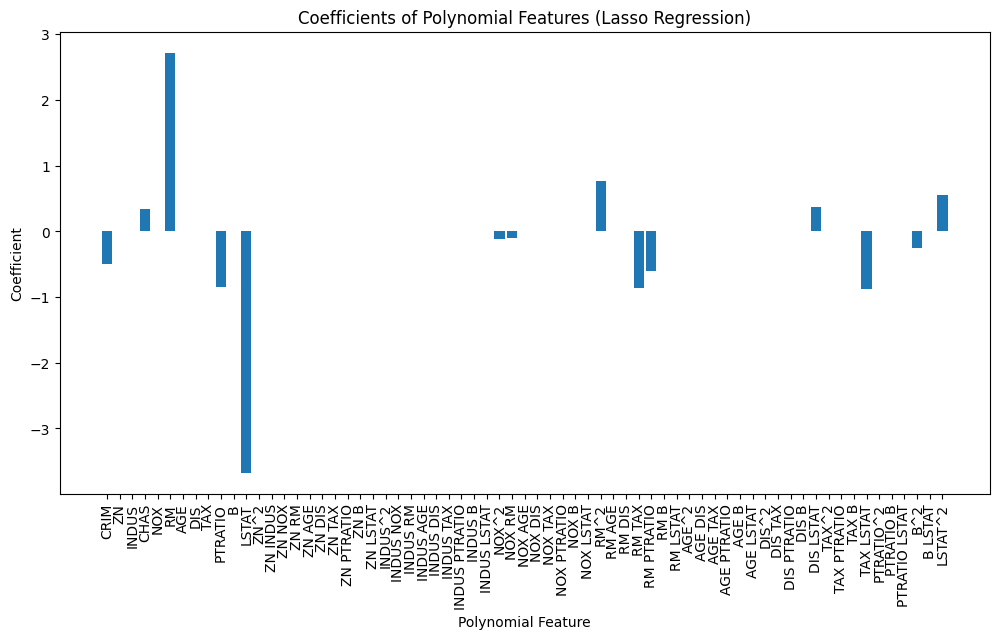

In [86]:
lasso_coefficients = lasso_regressor.coef_

# Visualize the coefficients
plt.figure(figsize=(12, 6))
plt.bar(data_with_poly_features.columns, lasso_coefficients)
plt.title('Coefficients of Polynomial Features (Lasso Regression)')
plt.xlabel('Polynomial Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

1- What observations can you make about the weight distribution when applying L1 regularization?

2- How do different values of the regularization parameter (alpha) affect the sparsity of the model coefficients?

    Your Answer Goes here.
1- As we can see, some of the wights will be zero. This is because L1 regularization makes the model sparse.</br>
2- If we increase the value, more parameters will be set to zero as the non-zero penalty is getting higher.

Get the score value on train *dataset*


In [95]:
# TODO: Calculate R² score and MSE on the training dataset
y_train_pred_lasso = lasso_regressor.predict(X_train)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)

print("R² score on training set:", r2_train_lasso)
print("Mean Squared Error (MSE) on training set:", mse_train_lasso)

R² score on training set: 0.8151020481609801
Mean Squared Error (MSE) on training set: 16.062714437997908


Predict the value of "y" for each "x" belonging to the "testing" set

In [88]:
y_test_pred_lasso = lasso_regressor.predict(X_test)

# Ridge Regularization(L2)

L2 regularization, also known as Ridge regularization, is a technique used in regression models to prevent overfitting by adding a penalty equivalent to the square of the magnitude of coefficients to the loss function.
</br>
Train a regression model using L2 regularization.

In [89]:
# TODO: Use Ridge from sklearn library
ridge_regressor = Ridge(alpha=10)
ridge_regressor.fit(X_train, y_train)

Ridge(alpha=10)

Get the coefficients of the variables and visualize it.

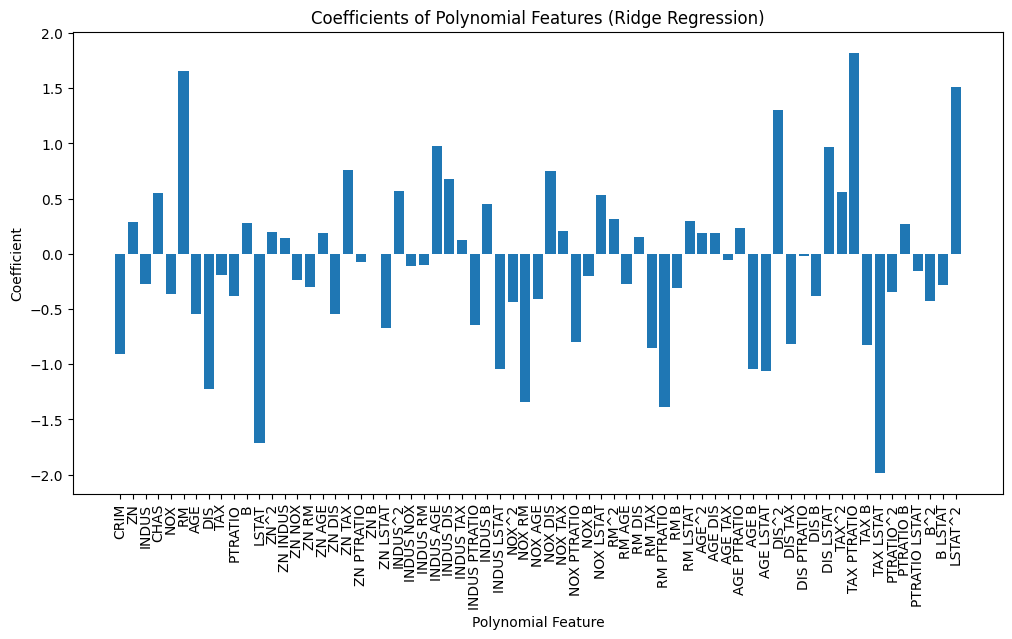

In [92]:
ridge_coefficients = ridge_regressor.coef_

plt.figure(figsize=(12, 6))
plt.bar(data_with_poly_features.columns, ridge_coefficients)
plt.title('Coefficients of Polynomial Features (Ridge Regression)')
plt.xlabel('Polynomial Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

Compare the effect on coefficients between L1 and L2 regularization. What are the key differences?

 How does the regularization parameter influence the magnitude of the coefficients in Ridge Regression?

        Your answer goes here
1- In L1 the model parameters will be sparse and some of the weights are set to zero. Here however it just controls them so that they don't become so large. In L2 it doesn't try to make the coeffiecents zero. It just makes them smaller.</br>
2- If you increase alpha, it will result in smaller weights because the weights will be more penalized.

Get the score value on train *dataset*

In [96]:
# TODO: Calculate R² score and MSE on the training dataset
y_train_pred_ridge = ridge_regressor.predict(X_train)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)

print("R² score on training set:", r2_train_ridge)
print("Mean Squared Error (MSE) on training set:", mse_train_ridge)

R² score on training set: 0.895523325579941
Mean Squared Error (MSE) on training set: 9.076244328018214


Predict the value of "y" for each "x" belonging to the "testing" set



In [94]:
y_test_pred_ridge = ridge_regressor.predict(X_test)

# Summarization

Summarize the performance metrics (e.g., RMSE, R² score) of the basic regression model, Lasso regression, and Ridge regression in a table for easy comparison.(On both test and train data)</br>
if you are not familiar with R-squared concept see the link below:
[R-squared](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)


In [97]:
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

metrics_dict = {
    "Model": ["Basic Regression", "Lasso Regression", "Ridge Regression"],
    "MSE(Test)": [mse_test, mse_test_lasso, mse_test_ridge],
    "MSE(Train)": [mse_train, mse_train_lasso, mse_train_ridge],
    "R² Score (Test)": [r2_test, r2_test_lasso, r2_test_ridge],
    "R² Score (Train)": [r2_train, r2_train_lasso, r2_train_ridge]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,MSE(Test),MSE(Train),R² Score (Test),R² Score (Train)
0,Basic Regression,15.128774,9.076244,0.793700,0.895523
1,Lasso Regression,16.510401,16.062714,0.774860,0.815102
2,Ridge Regression,13.462112,9.076244,0.816427,0.895523


 *Which model performed best on the test data?</br>
Why the results on train data are different? </br>
Discuss why this might be the case.*

          your answer goes here.
1- Ridge Regression model performed the best on the test data, as it has the lowest MSE(Test) and highest R² Score (Test) among the three models. </br>
2- The results on the train data are different because each regularization technique imposes different constraints on the model coefficients during training. As we can see the lasso was outperformed by the two other methods. It is because lasso made some coefficients zero and it is not the optimal case. The reason basic and ridge are equal is that the alpha for ridge wasn't so big so they almost have the same performance.</br>
3- I think because all the features have some importance for this model and because lasso ignores some of them, it is outperformed by the other two methods. And ridge is the best because it balances the weights so that they are not extremely high.